In [1]:
from itertools import product

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from download_data import get_price, get_mpd
from explore_data import calc_rolling_stat, plot_change_scatter

In [2]:
column_def = pd.read_csv("../data/column_def.csv")
column_def

,name,description
0,maturity_target,The time-to-expiry target for options selection
1,mu,The mean of the MPD; mu = sum(probability at ...
2,sd,The standard deviation of the MPD; sd = sqrt(...
3,skew,The skew of the MPD; skew = sum(probability a...
4,kurt,The kurtosis of the MPD; kurt = sum(probabili...
5,p10,The 10th percentile of the MPD
6,p50,The 50th percentile of the MPD
7,p90,The 90th percentile of the MPD
8,lg_change_prob,The change in the expected return in percentag...
9,prDec,"The probability of a ""large decline"" in return..."


In [3]:
data = get_mpd()

In [4]:
data[["market", "type"]].drop_duplicates().groupby("type").count()

,market
type,
commodity,6
equity,2
equity_idx,3
fx,3
inflation,3
rate,4


In [5]:
equity = data.loc[data["type"].isin(["equity", "equity_idx"])]
tickers = equity["market"].unique()
start_date, end_date = equity["idt"].min(), equity["idt"].max()
print(f"""Equity / Equity Index include: {tickers},
Data Period: {start_date} - {end_date}""")

Equity / Equity Index include: ['bac' 'citi' 'iyr' 'sp12m' 'sp6m'],
Data Period: 2007-01-12 00:00:00 - 2024-01-10 00:00:00


In [6]:
equity.groupby("market").first()

,idt,maturity_target,mu,sd,skew,kurt,p10,p50,p90,lg_change_decr,prDec,lg_change_incr,prInc,name,type
market,,,,,,,,,,,,,,,
bac,2010-01-15 00:00:00,3.0,-0.025140,0.182100,-0.381730,0.851920,-0.253890,-0.016340,0.192720,-20.0,0.148980,20.0,0.093070,Bank of America Corporation,equity
citi,2010-01-15 00:00:00,3.0,-0.027030,0.216670,-0.126270,1.298230,-0.289140,-0.022310,0.226320,-20.0,0.182470,20.0,0.123160,"Citigroup, Inc.",equity
iyr,2010-10-29 00:00:00,3.0,-0.015380,0.136965,-0.948440,1.454774,-0.196561,0.005729,0.135344,-20.0,0.097426,20.0,0.022713,iShares real estate index,equity_idx
sp12m,2007-01-12 00:00:00,12.0,0.034318,0.132616,-1.055814,1.657518,-0.142450,0.057748,0.176416,-20.0,0.061515,20.0,0.056906,"S&P 500, 12-months-out",equity_idx
sp6m,2007-01-12 00:00:00,6.0,0.018803,0.086435,-1.079705,1.837194,-0.095498,0.033820,0.111149,-20.0,0.024242,20.0,0.001915,"S&P 500, 6-months-out",equity_idx


Manually translate name -> stock ticker. SPX is not a tradeable asset, therefore using SPY ETF as approximation.

Also, we can't fetch BAC data with others, hence do it separately.

In [7]:
close = get_price(tickers=["BAC", "C", "IYR", "SPY"], 
                  start_date=start_date, 
                  end_date=end_date, 
                  use_cache=True)

Since sp12m / sp6m get maturity = 12 / 6, we assume maturity means X-month and calculate log return for the period of maturity target.

In [8]:
# represent: bac, citi, iyr, sp6m, sp12m

stat = pd.concat([
    calc_rolling_stat(close[["BAC", "C", "IYR"]], 3).stack(level=0),
    calc_rolling_stat(close[["SPY"]], 6).stack(level=0),
    calc_rolling_stat(close[["SPY"]], 12).stack(level=0),
], axis=1)
stat.columns = ["bac", "citi", "iyr", "sp6m", "sp12m"]
stat.columns.name = "market"
stat = stat.unstack().T.swaplevel().T
stat

,ret,vol,ret_max,ret_min,ret,vol,ret_max,ret_min,ret,vol,ret_max,ret_min,ret,vol,ret_max,ret_min,ret,vol,ret_max,ret_min
market,bac,bac,bac,bac,citi,citi,citi,citi,iyr,iyr,iyr,iyr,sp6m,sp6m,sp6m,sp6m,sp12m,sp12m,sp12m,sp12m
date,,,,,,,,,,,,,,,,,,,,
2007-01-12,-0.042482,0.840329,0.018863,-0.058925,-0.033882,11.106897,0.014493,-0.091667,-0.059543,1.482007,0.024647,-0.094947,0.090648,3.240158,0.092882,-0.019625,0.007466,2.548187,0.060196,-0.048409
2007-01-16,-0.039702,0.837569,0.018863,-0.058925,-0.034851,10.971715,0.014493,-0.091667,-0.048668,1.473485,0.024647,-0.094947,0.076307,3.247681,0.092882,-0.019625,-0.000878,2.546113,0.054361,-0.054244
2007-01-17,-0.038920,0.776642,0.003707,-0.074081,-0.023895,10.194702,0.000000,-0.106160,-0.068602,1.360805,0.004946,-0.114649,0.102997,3.190631,0.112508,0.000000,-0.017690,2.561683,0.044976,-0.063629
2007-01-18,-0.041262,0.734798,0.000000,-0.077788,-0.029450,9.806726,0.001662,-0.104129,-0.050939,1.275201,0.008401,-0.111194,0.111242,3.082197,0.111242,-0.001430,-0.026483,2.557558,0.044976,-0.063629
2007-01-19,-0.031176,0.679655,0.000000,-0.077788,-0.022393,9.358757,0.000000,-0.105791,-0.062902,1.190247,0.000000,-0.119595,0.112853,3.012470,0.112853,-0.002793,-0.025640,2.566012,0.046302,-0.062303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-06,0.184380,2.171454,0.188514,-0.028645,0.246094,3.372202,0.246094,-0.012928,0.137701,4.973246,0.166225,-0.019823,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-09,0.202848,2.191756,0.202848,-0.028645,0.256455,3.481436,0.256455,-0.012928,0.135473,4.965292,0.166225,-0.019823,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
log_ret = stat["ret"].stack().swaplevel().rename("ret")
stat["ret"].describe()

market,bac,citi,iyr,sp6m,sp12m
count,4217.000000,4217.000000,4217.000000,4157.000000,4037.000000
mean,-0.000854,-0.018829,0.005882,0.028520,0.057484
std,0.197576,0.206733,0.100007,0.093560,0.140279
min,-1.490623,-1.934910,-0.871826,-0.524336,-0.601200
25%,-0.075012,-0.085952,-0.026697,-0.009421,0.000116
50%,0.016748,0.009197,0.018504,0.044742,0.086869
75%,0.092155,0.078527,0.055010,0.083550,0.137086
max,1.329371,1.342492,0.451701,0.381325,0.494729


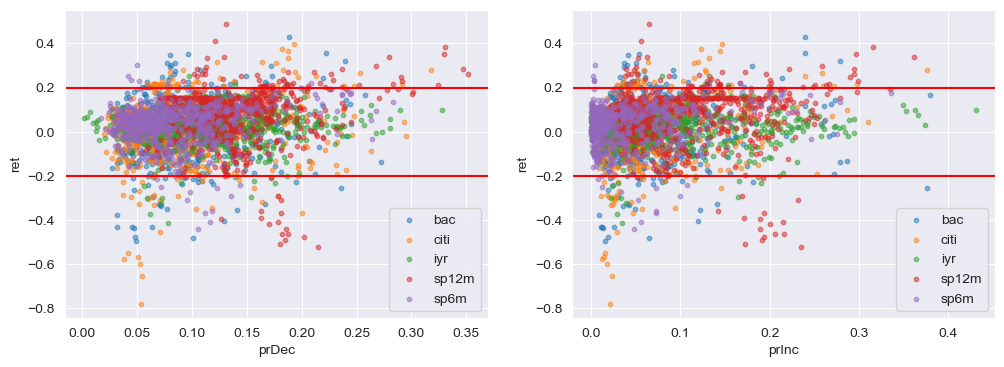

In [10]:
avg_prob = plot_change_scatter(log_ret, df_mpd=equity)

In [11]:
avg_prob

prDec                         prInc                    
large_change        -1         0         1        -1         0         1
market                                                                  
bac           0.088489  0.092378  0.107882  0.064849  0.064325  0.083049
citi          0.082122  0.091460  0.131030  0.039589  0.058241  0.102804
iyr           0.107222  0.121187  0.141057  0.086313  0.089827  0.120213
sp12m         0.173250  0.132620  0.192146  0.185759  0.096838  0.153531
sp6m          0.105938  0.081202  0.085297  0.053838  0.033547  0.035687

Both plot and average probability in different actual log return scenario shows:
- prDec / prInc are only positively correlated with log return (correct only in case of prInc)
- SPY has a skewed convex shape, i.e. when no large change log_return, both prDec / prInc are low (this is correct). However, when there is a large change both prInc / prDec has large value. 

Our strategy maybe more related to volatility? i.e. large change or no change
e.g. spread trading but adjusting price band size regularly based on probability estimation

prDec               prInc          
large_change         0         1         0         1
market                                              
bac           0.062235  0.093544  0.038485  0.065904
citi               NaN  0.093844       NaN  0.060527
iyr                NaN  0.121002       NaN  0.089911
sp12m              NaN  0.138234       NaN  0.103431
sp6m               NaN  0.081677       NaN  0.033925

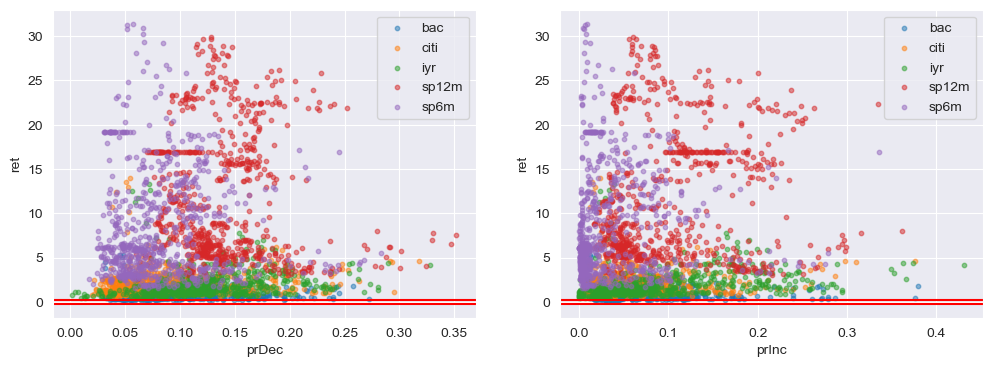

In [18]:
plot_change_scatter(stat["vol"].stack().swaplevel().rename("ret"), df_mpd=equity)

prDec               prInc          
large_change         0         1         0         1
market                                              
bac           0.090062  0.122502  0.061920  0.099882
citi          0.088389  0.143203  0.054208  0.117709
iyr           0.120655  0.171520  0.089309  0.177517
sp12m         0.132166  0.197114  0.097414  0.161814
sp6m          0.080445  0.140755  0.032297  0.111925

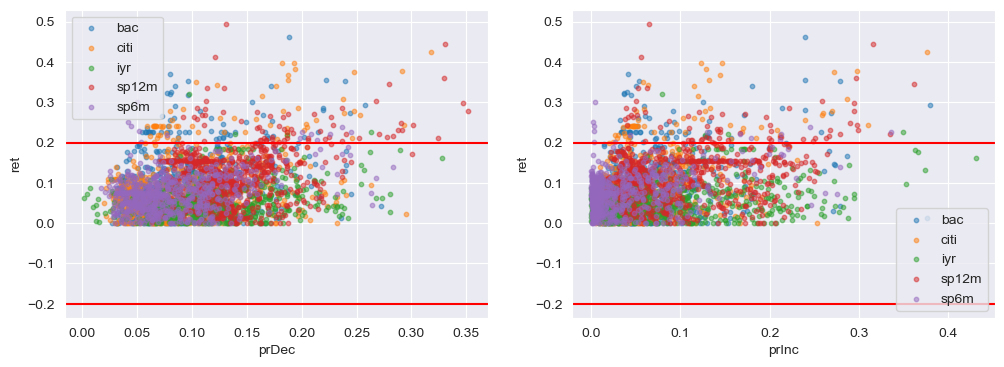

In [16]:
plot_change_scatter(stat["ret_max"].stack().swaplevel().rename("ret"), df_mpd=equity)

prDec               prInc          
large_change        -1         0        -1         0
market                                              
bac           0.099898  0.092568  0.078525  0.064340
citi          0.103234  0.092899  0.060764  0.060503
iyr           0.113597  0.121251  0.094823  0.089746
sp12m         0.137717  0.138304  0.102207  0.103596
sp6m          0.097885  0.080725  0.052217  0.032850

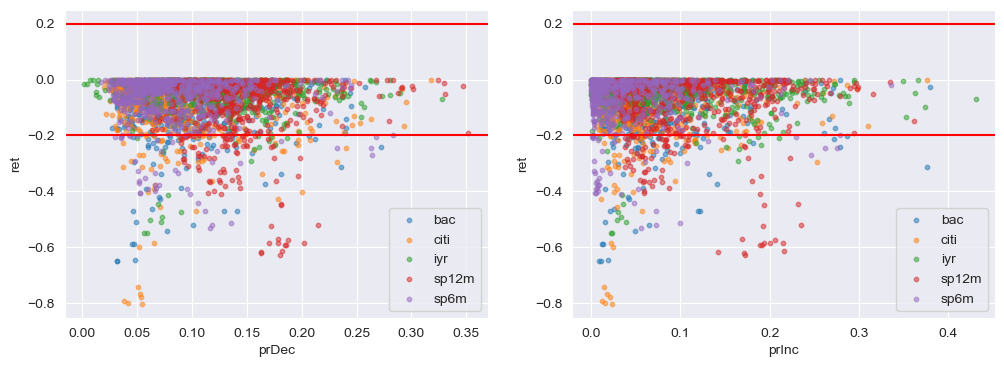

In [17]:
plot_change_scatter(stat["ret_min"].stack().swaplevel().rename("ret"), df_mpd=equity)

### Probability Correlation

<Axes: xlabel='market', ylabel='market'>

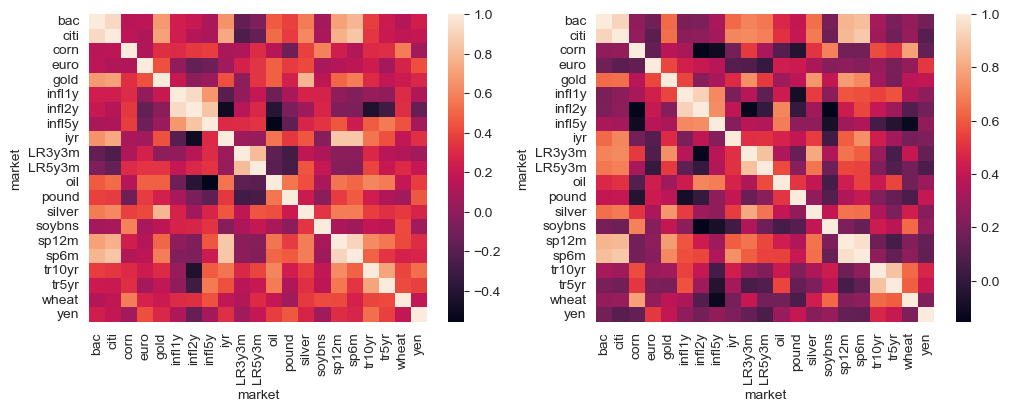

In [12]:
from seaborn import heatmap
unique_tickers = data["market"].unique()

inc_corr = data.set_index(["idt", "market"])["prInc"].unstack().corr().reindex(unique_tickers).T.reindex(unique_tickers).T
dec_corr = data.set_index(["idt", "market"])["prDec"].unstack().corr().reindex(unique_tickers).T.reindex(unique_tickers).T


fig, ax = plt.subplots(1, 2, figsize=(12, 4))

heatmap(inc_corr, ax=ax[0])
heatmap(dec_corr, ax=ax[1])

In [13]:
inc_corr_unstack = inc_corr.unstack().sort_values()
inc_corr_unstack = inc_corr_unstack.loc[inc_corr_unstack != 1]

pd.concat([
    inc_corr_unstack.head(),
    inc_corr_unstack.tail()
])

market  market
oil     infl5y   -0.558074
infl5y  oil      -0.558074
infl2y  iyr      -0.495354
iyr     infl2y   -0.495354
tr10yr  infl2y   -0.428932
sp6m    sp12m     0.902828
bac     citi      0.922992
citi    bac       0.922992
infl1y  infl2y    0.928834
infl2y  infl1y    0.928834
dtype: float64

In [14]:
dec_corr_unstack = dec_corr.unstack().sort_values()
dec_corr_unstack = dec_corr_unstack.loc[dec_corr_unstack != 1]

pd.concat([
    dec_corr_unstack.head(),
    dec_corr_unstack.tail()
])

market  market
infl2y  corn     -0.154837
corn    infl2y   -0.154837
infl2y  soybns   -0.150808
soybns  infl2y   -0.150808
LR3y3m  infl2y   -0.140856
infl2y  infl1y    0.921013
bac     citi      0.931003
citi    bac       0.931003
sp6m    sp12m     0.967133
sp12m   sp6m      0.967133
dtype: float64

# TODO
1. how about predict volatility / reversal 
2. how about max / min return during the period